In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix, kde_1d
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

### Setting up the pyabc run

In [2]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [3]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/data_adults_eggs.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'0_4_Adults_mean': 17152.0,
 '10_4_Adults_mean': 14350.0,
 '20_4_Adults_mean': 11823.0,
 '40_4_Adults_mean': 12679.0,
 '80_4_Adults_mean': 12095.0,
 '160_4_Adults_mean': 11954.0,
 '0_5_Adults_mean': 19216.0,
 '10_5_Adults_mean': 17330.0,
 '20_5_Adults_mean': 15110.0,
 '40_5_Adults_mean': 10917.0,
 '80_5_Adults_mean': 7923.0,
 '160_5_Adults_mean': 5980.0,
 '0_6_Adults_mean': 18229.0,
 '10_6_Adults_mean': 17481.0,
 '20_6_Adults_mean': 17078.0,
 '40_6_Adults_mean': 15322.0,
 '80_6_Adults_mean': 6599.0,
 '160_6_Adults_mean': 2245.0,
 '0_7_Adults_mean': 12589.0,
 '10_7_Adults_mean': 14229.0,
 '20_7_Adults_mean': 18951.0,
 '40_7_Adults_mean': 17520.0,
 '80_7_Adults_mean': 16514.0,
 '160_7_Adults_mean': 478.0,
 '0_4_Adults_sd': 3874.0,
 '10_4_Adults_sd': 5023.0,
 '20_4_Adults_sd': 4745.0,
 '40_4_Adults_sd': 5132.0,
 '80_4_Adults_sd': 4682.0,
 '160_4_Adults_sd': 3807.0,
 '0_5_Adults_sd': 4729.0,
 '10_5_Adults_sd': 3807.0,
 '20_5_Adults_sd': 5023.0,
 '40_5_Adults_sd': 4847.0,
 '80_5_Adults_sd'

In [4]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0.0001, 0.1),
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0.0001, 0.1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(0.0001, 0.1), 
              AIAdultSlope=(1, 9),
              AILarvaLD50=(0.0001, 0.1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [5]:
# Set our distance function and sampler
distance = pyabc.PNormDistance(p=1)

sampler = DaskDistributedSampler(dask_client = client)

transition = LocalTransition()

In [6]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(500, max_population_size = 500),
             #population_size=25,
             transitions = transition,
             sampler=sampler)

In [7]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_3_11.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=1, start_time=2019-03-11 16:56:01.806272, end_time=None)>
INFO:Epsilon:initial epsilon is 244111.63811650296


1

In [8]:
history = abc.run(max_nr_populations=30, minimum_epsilon=0)

INFO:ABC:t:0 eps:244111.63811650296
INFO:ABC:t:1 eps:221549.14274167328
INFO:Adaptation:Change nr particles 500 -> 500


KeyboardInterrupt: 

In [7]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2019-03-11 16:56:05.391511,0,0.000000,1
1,0,2019-03-12 07:09:25.752604,963,244111.638117,500
2,1,2019-03-13 05:03:42.477176,1161,221549.142742,500
3,2,2019-03-14 06:47:42.578726,1404,210220.408074,500
4,3,2019-03-16 04:11:05.040127,1692,202346.625814,500


In [8]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 51.9%
Gen 2: 43.1%
Gen 3: 35.6%
Gen 4: 29.6%


In [ ]:
history.total_nr_simulations

### Visualize results

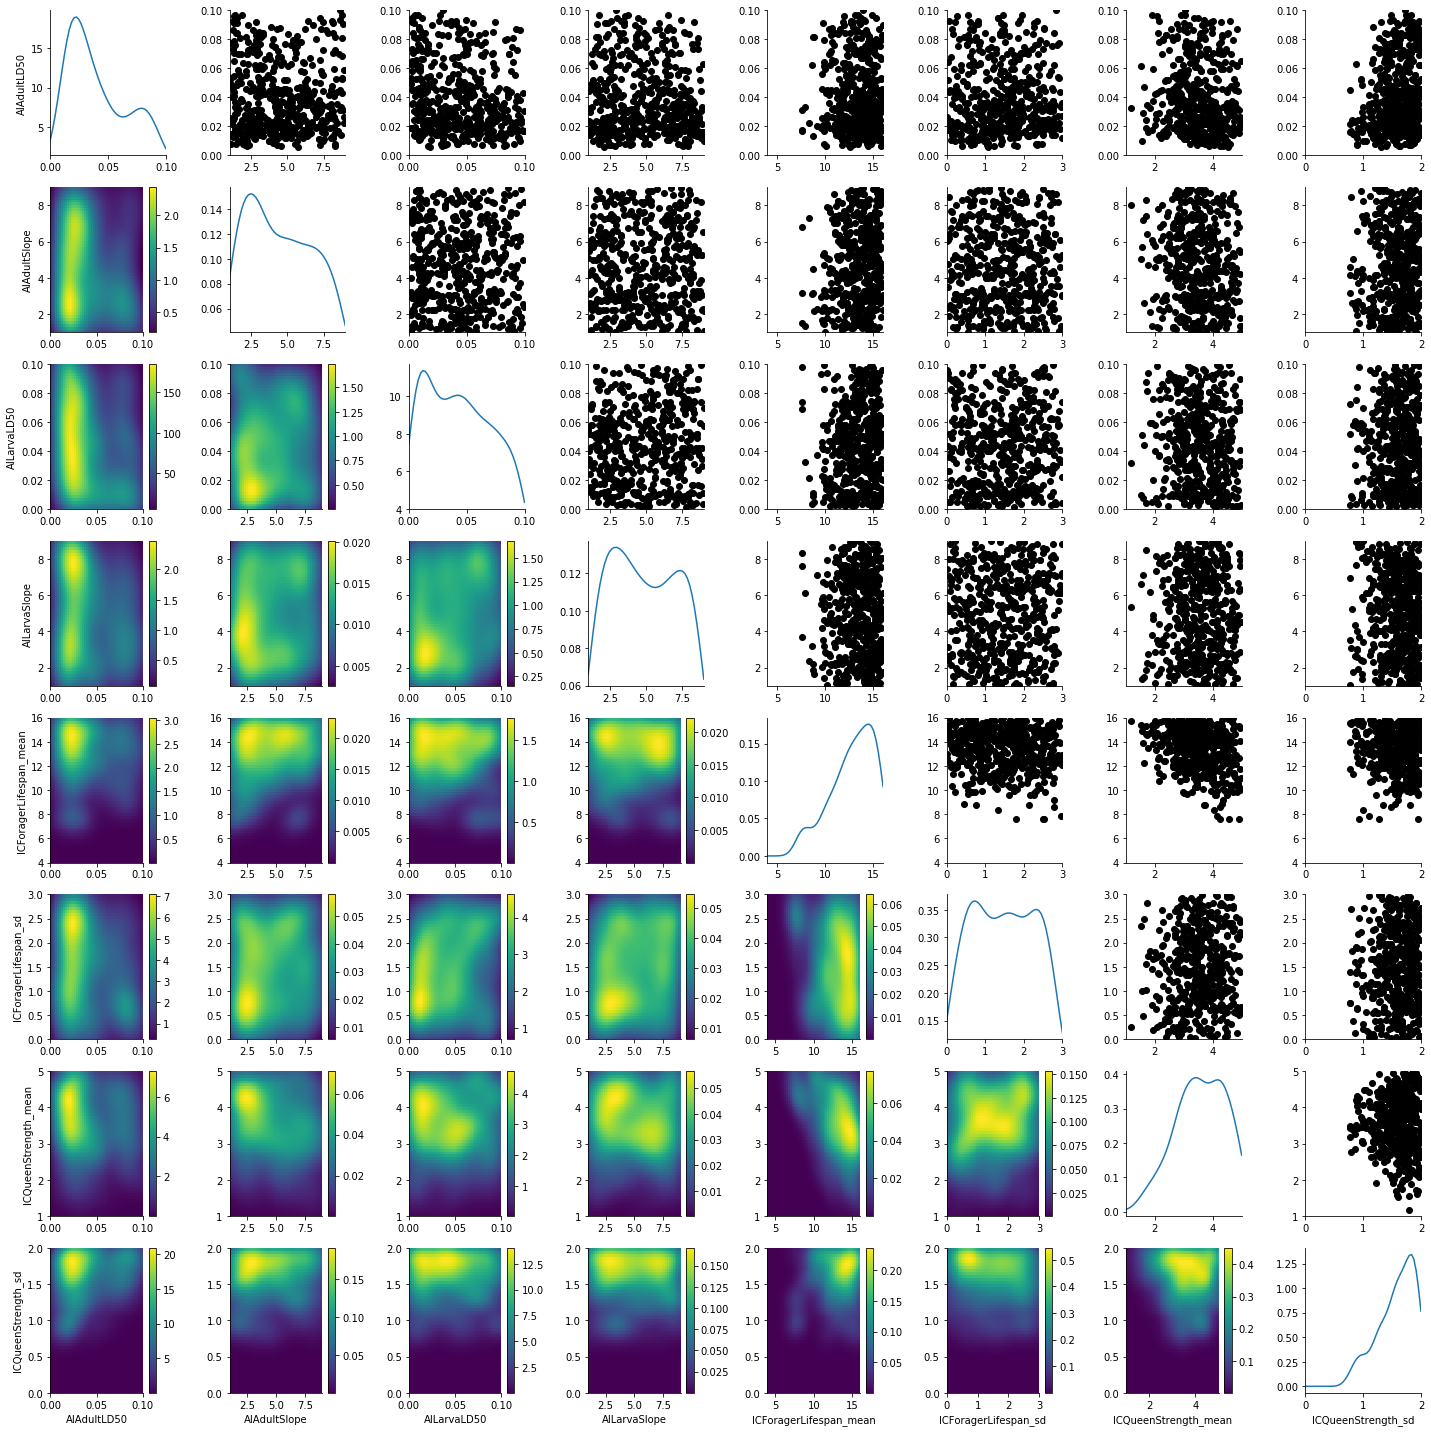

In [9]:
df, w = history.get_distribution(m=0, t=history.max_t)
plot_kde_matrix(df, w, limits=limits);

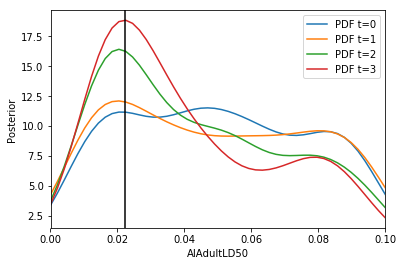

In [10]:
variable = 'AIAdultLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0.0001, xmax=0.1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (0.05,0.75))
plt.show()

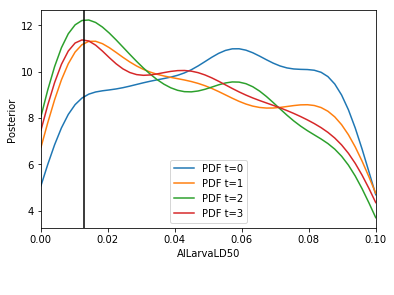

In [11]:
variable = 'AILarvaLD50'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0.0001, xmax=0.1,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(MAP.item()), xy = (0.05,0.75))
plt.show()

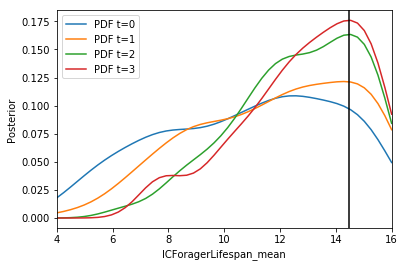

In [12]:
variable = 'ICForagerLifespan_mean'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1,1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=4, xmax=16,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
#ax.annotate('Max: {:.2f} days'.format(MAP.item()), xy = (5.5,0.4))
ax.legend()
plt.show()

### Visualize from a stored run

In [6]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_3_11.db"))
history = History(db_path)
history.id = 1

In [ ]:
history

In [ ]:
df, w = history.get_distribution(m=0, t=9)

In [ ]:
plot_kde_matrix(df, w, limits=limits);

In [ ]:
history.get_all_populations()

In [ ]:
#get the maximum a posteriori estimation for AdultLD50
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_ld50_map = MAP.item() #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AIAdultLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_ld50_median = x.item(np.min(np.where(cdf > .5))) #un-log transformed and converted to ng/bee
print('Adult LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(adult_ld50_map, adult_ld50_median))

# calculate 95% credible interval
adult_ld50_lower = x.item(np.min(np.where(cdf > .025)))
adult_ld50_upper = x.item(np.min(np.where(cdf > .975)))
print("95% CI: {} - {}".format(adult_ld50_lower, adult_ld50_upper))

In [ ]:
#get the maximum a posteriori estimation for LarvaLD50
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
larva_ld50_map = MAP.item() #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"AILarvaLD50", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
larva_ld50_median = x.item(np.min(np.where(cdf > .5))) #un-log transformed and converted to ng/bee
print('Larva LD50 MAP: {:.2f} ng/bee, median: {:.2f} ng/bee'.format(larva_ld50_map, larva_ld50_median))

# calculate 95% credible interval
larva_ld50_lower = x.item(np.min(np.where(cdf > .025)))
larva_ld50_upper = x.item(np.min(np.where(cdf > .975)))
print("95% CI: {} - {}".format(larva_ld50_lower, larva_ld50_upper))

In [ ]:
np.median(df['AIAdultLD50']), np.mean(df['AIAdultLD50'])

In [ ]:
np.median(df['AILarvaLD50']), np.mean(df['AILarvaLD50'])

### Continuing a stopped run

In [13]:
#retrieve stored run 
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "run_3_11.db"))
#db = History(db_path)
#db.id = 3

In [15]:
# define the ABCSMC object
abc_cont = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(500, max_population_size = 500),
             transitions = transition,
             sampler=sampler)

In [ ]:
abc_cont.load(db_path,1)

INFO:Epsilon:initial epsilon is 194696.81714186104


1

In [ ]:
abc_cont.run(minimum_epsilon=0, max_nr_populations=30)

INFO:ABC:t:4 eps:194696.81714186104
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:5 eps:189350.87001484507
INFO:Adaptation:Change nr particles 500 -> 500
INFO:ABC:t:6 eps:185265.32713621669
INFO:Adaptation:Change nr particles 500 -> 500
